In [1]:
# if necessary, install NeuralGCM and dependencies
!python --version
!pip install -q -U neuralgcm dinosaur-dycore gcsfs
!pip install matplotlib
!pip install cartopy

Python 3.11.10


## Background and Motivation

<span style="color:blue">Todo later</span> Rewrite Introduction, add any relevant thins into here
Droughts are natural disasters that are getting worse every year and therefore affecting millions of people by increasing the risk of malnutrition, diseases, wildfires, or forced migration due to droughts. Developing early warning systems and timely interventions is crucial to mitigate the economic, social, and environmental impacts of droughts.



<span style="color:blue"> Add other necessary information

## Data and Objectives

Todo: Add if something is missing
Data: \
ERA 5 data \
pretrained NeuralGCM model (intermediate deterministic NeuralGCM 1.4 model) \
SST data 

Objectives: \
The aim of this project is to make a 30-year roll-out prediction for drought frequency and amplitudes in the region of Spain. 

## Drought specific variables

Evapotranspiration (not in NeuralGCM) \
Precipitation (not in NeuralGCM) \
Temperature \
Specific_humidity \
Sea Surface Temperature (not in NeuralGCM)

In [2]:
import gin
gin.enter_interactive_mode()
import gcsfs
import jax
import numpy as np
import pickle
import xarray

from dinosaur import horizontal_interpolation
from dinosaur import spherical_harmonic
from dinosaur import xarray_utils
import neuralgcm

import matplotlib.pyplot as plt
import cartopy

from PIL import Image
from IPython.display import display

gcs = gcsfs.GCSFileSystem(token='anon')

In [3]:
! pip install xarray netCDF4 numpy

import xarray as xr


Subset the data to be similar to NeuralGCM

## Load a pre-trained NeuralGCM model

```{caution}
Trained model weights are licensed for non-commercial use, under the Creative Commons [Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/) license (CC BY-NC-SA 4.0).
```

Pre-trained model checkpoints from the NeuralGCM paper are [available for download](https://console.cloud.google.com/storage/browser/gresearch/neuralgcm/04_30_2024) on Google Cloud Storage:

- Deterministic models:
    - `gs://gresearch/neuralgcm/04_30_2024/neural_gcm_dynamic_forcing_deterministic_0_7_deg.pkl`
    - `gs://gresearch/neuralgcm/04_30_2024/neural_gcm_dynamic_forcing_deterministic_1_4_deg.pkl`
    - `gs://gresearch/neuralgcm/04_30_2024/neural_gcm_dynamic_forcing_deterministic_2_8_deg.pkl`
- Stochastic models:
    - `gs://gresearch/neuralgcm/04_30_2024/neural_gcm_dynamic_forcing_stochastic_1_4_deg.pkl`

## Need to train it on our own using the inputs from era5

## Load and modify the model configuration string

Ensure that the new variables (precipitation, soil moisture, evapotranspiration) are available in your dataset and properly preprocessed. The data should be regridded to match NeuralGCM's native grid and provided in the correct units. Refer to NeuralGCM's data preparation guidelines for detailed instructions.

In [4]:
gcs = gcsfs.GCSFileSystem(token='anon')
model_name = 'neural_gcm_dynamic_forcing_deterministic_2_8_deg.pkl'
with gcs.open(f'gs://gresearch/neuralgcm/04_30_2024/{model_name}', 'rb') as f:
    ckpt = pickle.load(f)

new_inputs_to_units_mapping = {
    'u': 'meter / second',
    'v': 'meter / second',
    't': 'kelvin',
    'z': 'm**2 s**-2',
    'sim_time': 'dimensionless',
    'tracers': {'specific_humidity': 'dimensionless',
                'specific_cloud_liquid_water_content': 'dimensionless',
                'specific_cloud_ice_water_content': 'dimensionless',
    },

    'diagnostics': {
        'surface_pressure': 'kg / (meter s**2)',
        'sst_anomalies': 'kelvin',  # SST anomalies in Kelvin
        'P_minus_E_cumulative': 'kg / (meter**2)'
        # Add new diagnostic variables if any
    }
}

new_model_config_str = '\n'.join([
        ckpt['model_config_str'],
        f'DimensionalLearnedPrimitiveToWeatherbenchDecoder.inputs_to_units_mapping = {new_inputs_to_units_mapping}',
        'DimensionalLearnedPrimitiveToWeatherbenchDecoder.diagnostics_module = @NodalModelDiagnosticsDecoder',
        'StochasticPhysicsParameterizationStep.diagnostics_module = @PrecipitationMinusEvaporationDiagnostics',
        'PrecipitationMinusEvaporationDiagnostics.method = "cumulative"',
        'PrecipitationMinusEvaporationDiagnostics.moisture_species =  ("specific_humidity", "specific_cloud_liquid_water_content", "specific_cloud_ice_water_content")',])

ckpt['model_config_str'] = new_model_config_str

model = neuralgcm.PressureLevelModel.from_checkpoint(ckpt)

## Subset the data and compute some variables
<span style="color:red">TODO </span> SST still NAN for Spain

<span style="color:blue">TODO later </span> Add short info about AMO and SST Anomalies?

## <span style ="color:red"> Need to change start time and end time
Chose data: Start_time = 1940-01-01, End_time = 1989-12-31

In [5]:
lat_bounds = [slice(34, 45), slice(34, 51)] 
lon_bounds = [slice(-25, 19), slice(-20, 10)]  

## Load ERA5 data from GCP/Zarr

See {doc}`datasets` for details. Leave this part


In [6]:
era5_path = 'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3'
full_era5 = xarray.open_zarr(gcs.get_mapper(era5_path), chunks=None)

start_time = '2022-05-01'
end_time = '2022-06-16'
data_inner_steps = 24  # process every 24th hour


<span style="color:green"></span>Incorporate the processed SST data or derived indices into your drought prediction model as predictors or covariates.

In [7]:
print(full_era5["mean_total_precipitation_rate"])
for i in full_era5:
    if "wind" in i:
        print(i)

<xarray.DataArray 'mean_total_precipitation_rate' (time: 1323648,
                                                   latitude: 721,
                                                   longitude: 1440)> Size: 5TB
[1374264299520 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 11MB 1900-01-01 ... 2050-12-31T23:00:00
Attributes:
    long_name:   Mean total precipitation rate
    short_name:  mtpr
    units:       kg m**-2 s**-1
100m_u_component_of_wind
100m_v_component_of_wind
10m_u_component_of_neutral_wind
10m_u_component_of_wind
10m_v_component_of_neutral_wind
10m_v_component_of_wind
10m_wind_gust_since_previous_post_processing
instantaneous_10m_wind_gust
mean_direction_of_wind_waves
mean_period_of_wind_waves
mean_wave_period_based_on_first_moment_for_wind_waves
mean_wave_period_based_on_second_moment_for_

<span style="color:green">NEW</span> Add SST anomalies to the input variables of the NeuralGCM model
<span style="color:green">TODO</span> Error with too much data -> sliced or maybe on cluster

In [8]:
import pandas as pd

# Verify the change
print("Updated Dimensions:", full_era5.dims)
print("Updated Coordinates:", full_era5.coords)

# Step 1: Subset the region and time range

#time_bounds = slice('2000-01-01' ,'2020-12-31')
lat_bounds = slice(51, 34)  # Latitude bounds (51°N to 34°N)
lon_bounds = slice(-20, 10)  # Longitude bounds (-20°W to 10°E)

#subset = full_era5.sel(latitude=lat_bounds, longitude=lon_bounds, time=time_bounds)


# # Add SST anomalies and other relevant inputs to the dataset
# era5_with_sst = xr.Dataset(
#     {
#         'precipitation': subset.get('mean_total_precipitation_rate', None),
#         'temperature': subset.get('temperature', None),
#         'specific_humidity': subset.get('specific_humidity', None),
#         'sst_anomalies': sst_anomalies,
#         'evapotranspiration': subset.get('evaporation', None),
#         'soil_moisture': subset.get('volumetric_soil_water_layer_1', None),
#         'surface_pressure': subset.get('surface_pressure', None),
#     },
#     coords={
#         'time': subset['time'],
#         'latitude': subset['latitude'],
#         'longitude': subset['longitude'],
#     }
# )

# # Display the resulting smaller dataset
# print("Final dataset dimensions and variables:")
# print(era5_with_sst)

# era5_with_sst.to_netcdf("era5_with_sst.nc")


Updated Dimensions: FrozenMappingWarningOnValuesAccess({'time': 1323648, 'latitude': 721, 'longitude': 1440, 'level': 37})
Updated Coordinates: Coordinates:
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * level      (level) int64 296B 1 2 3 5 7 10 20 ... 875 900 925 950 975 1000
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 11MB 1900-01-01 ... 2050-12-31T23:00:00


Regrid to NeuralGCM's native resolution:

In [9]:
sliced_era5 = (
    full_era5
    [model.input_variables + model.forcing_variables]
    .pipe(
        xarray_utils.selective_temporal_shift,
        variables=model.forcing_variables,
        time_shift='24 hours',
    )
    .sel(time=slice(start_time, end_time, data_inner_steps))
    .compute()
)


In [10]:

era5_grid = spherical_harmonic.Grid(
    latitude_nodes=full_era5.sizes['latitude'],
    longitude_nodes=full_era5.sizes['longitude'],
    latitude_spacing=xarray_utils.infer_latitude_spacing(full_era5.latitude),
    longitude_offset=xarray_utils.infer_longitude_offset(full_era5.longitude),
)

regridder = horizontal_interpolation.ConservativeRegridder(
    era5_grid, model.data_coords.horizontal, skipna=True
)
    
eval_era5 = xarray_utils.regrid(sliced_era5, regridder)
eval_era5 = xarray_utils.fill_nan_with_nearest(eval_era5)


<span style="color:green">NEW</span>:Ensure that the combined dataset adheres to NeuralGCM’s expected format.

In [11]:
# Step 4: Initialize the model state and define forecast parameters
inner_steps = 24  # Save model outputs once every 24 hours
outer_steps = 10 * 24 // inner_steps  # Total of 31 days
timedelta = np.timedelta64(1, 'h') * inner_steps
times = (np.arange(outer_steps) * inner_steps)  # Time axis in hours

# Initialize model state
inputs = model.inputs_from_xarray(eval_era5.isel(time=0))
input_forcings = model.forcings_from_xarray(eval_era5.isel(time=0))
rng_key = jax.random.PRNGKey(42)  # Optional for deterministic models
initial_state = model.encode(inputs, input_forcings, rng_key)

# Use persistence for forcing variables (SST and sea ice cover)
all_forcings = model.forcings_from_xarray(eval_era5.head(time=1))

# Step 5: Make forecast
final_state, predictions = model.unroll(
    initial_state,
    all_forcings,
    steps=outer_steps,
    timedelta=timedelta,
    start_with_input=True,
)

# Convert predictions to xarray dataset
predictions_ds = model.data_to_xarray(predictions, times=times)

# Step 6: Post-process and save forecast results
forecast_dataset = predictions_ds
print(forecast_dataset)
# Save results to a NetCDF file
#forecast_dataset.to_netcdf('neuralgcm_forecast_2022.nc')

<xarray.Dataset> Size: 85MB
Dimensions:                              (time: 10, level: 37, longitude: 128,
                                          latitude: 64)
Coordinates:
  * longitude                            (longitude) float64 1kB 0.0 ... 357.2
  * latitude                             (latitude) float64 512B -87.86 ... 8...
  * level                                (level) int64 296B 1 2 3 ... 975 1000
  * time                                 (time) int64 80B 0 24 48 ... 192 216
Data variables:
    temperature                          (time, level, longitude, latitude) float32 12MB ...
    geopotential                         (time, level, longitude, latitude) float32 12MB ...
    sim_time                             (time) float32 40B ...
    specific_cloud_liquid_water_content  (time, level, longitude, latitude) float32 12MB ...
    specific_humidity                    (time, level, longitude, latitude) float32 12MB ...
    u_component_of_wind                  (time, level, 

## Make the forecast

See {doc}`trained_models` for details.

## Compare forecast to ERA5

See [WeatherBench2](https://sites.research.google/weatherbench/) for more comprehensive evaluations and archived NeuralGCM forecasts.

Can stay like this

In [31]:
# Selecting ERA5 targets from exactly the same time slice
target_trajectory = model.inputs_from_xarray(
    eval_era5
    .thin(time=(inner_steps // data_inner_steps))
    .isel(time=slice(outer_steps))
)
print("marco")
target_data_ds = model.data_to_xarray(target_trajectory, times=times)
print("polo")
combined_ds = xarray.concat([target_data_ds, predictions_ds], 'model')
print("marco")
combined_ds.coords['model'] = ['ERA5', 'NeuralGCM']

marco
polo
marco


/home/kit/iti/kd5572/miniconda3/envs/neuralgcm/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


('time', 'longitude', 'latitude')
Coordinates:
  * longitude  (longitude) float64 1kB 0.0 2.812 5.625 ... 351.6 354.4 357.2
  * latitude   (latitude) float64 512B -87.86 -85.1 -82.31 ... 82.31 85.1 87.86
  * time       (time) int64 80B 0 24 48 72 96 120 144 168 192 216


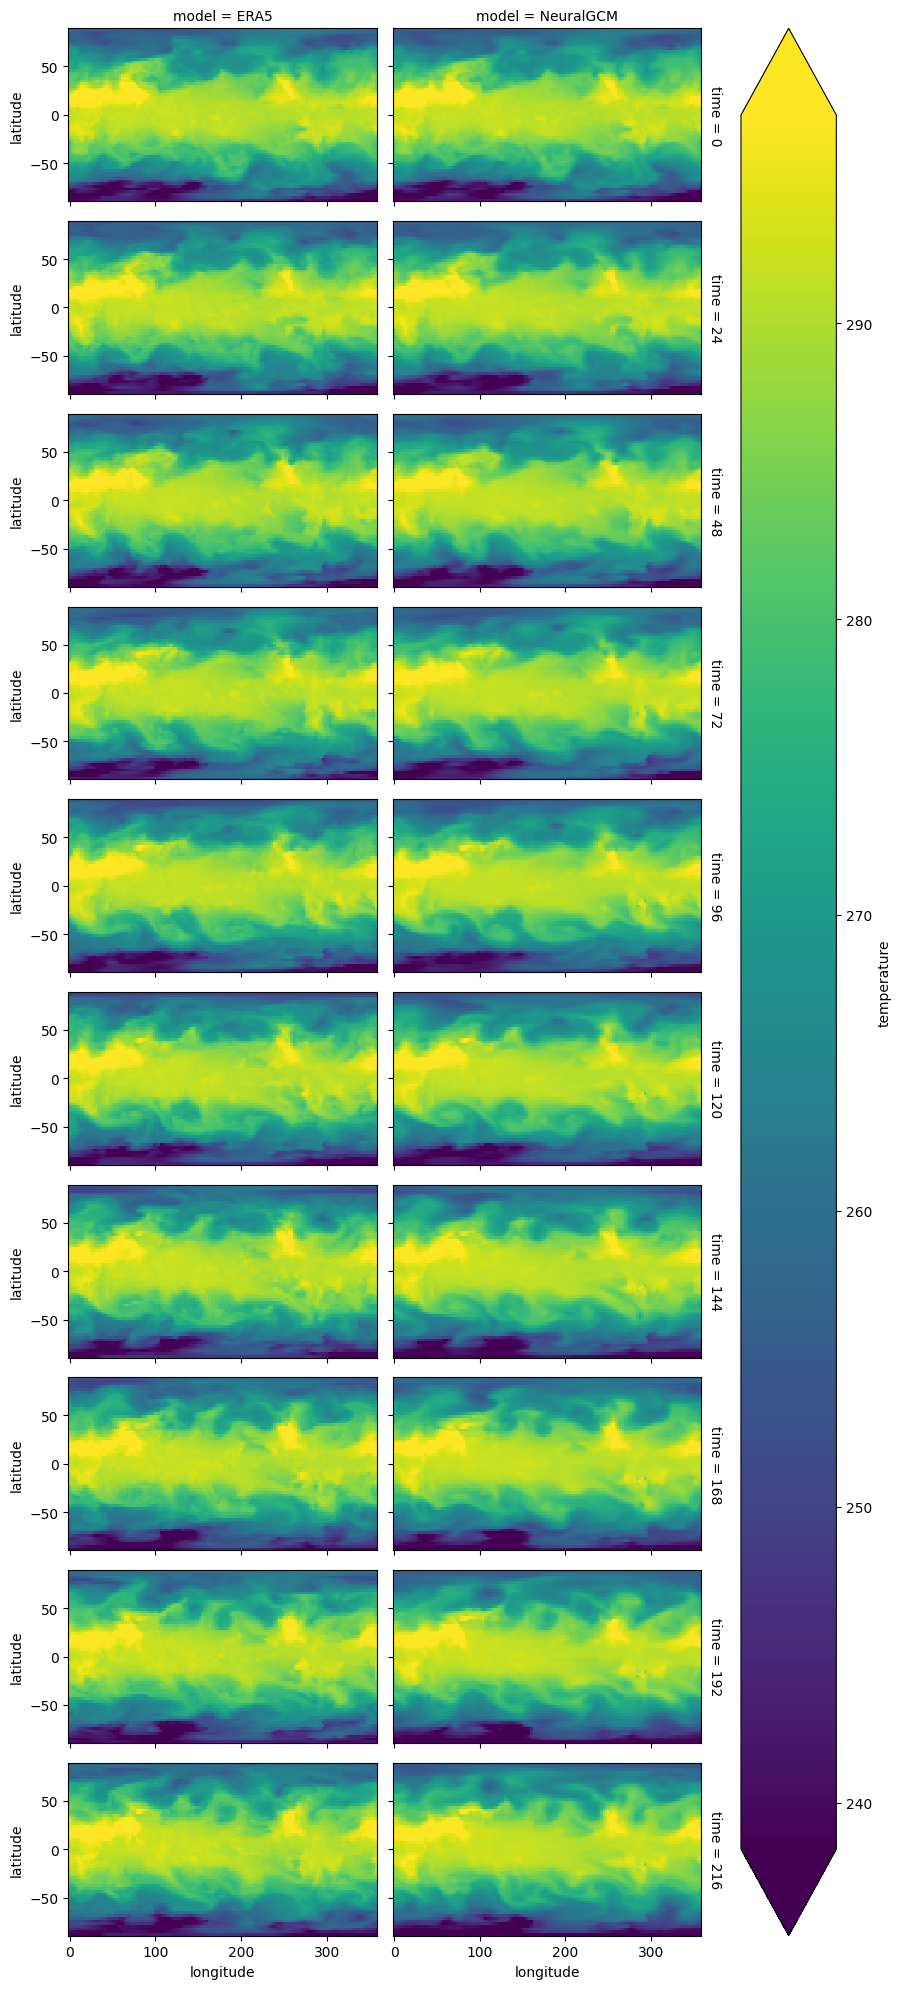

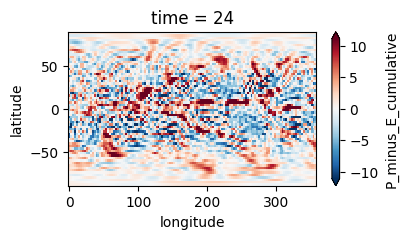

In [33]:
# Visualize ERA5 vs NeuralGCM trajectories
combined_ds.temperature.sel(level=850).plot(
    x='longitude', y='latitude', row='time', col='model', robust=True, aspect=2, size=2
)

print(predictions_ds.P_minus_E_cumulative.dims)
print(predictions_ds.P_minus_E_cumulative.coords)



predictions_ds.P_minus_E_cumulative.sel(time=24).plot(x='longitude', y='latitude', robust=True, aspect=2, size=2)


ValueError: cannot provide both `size` and `ax` arguments

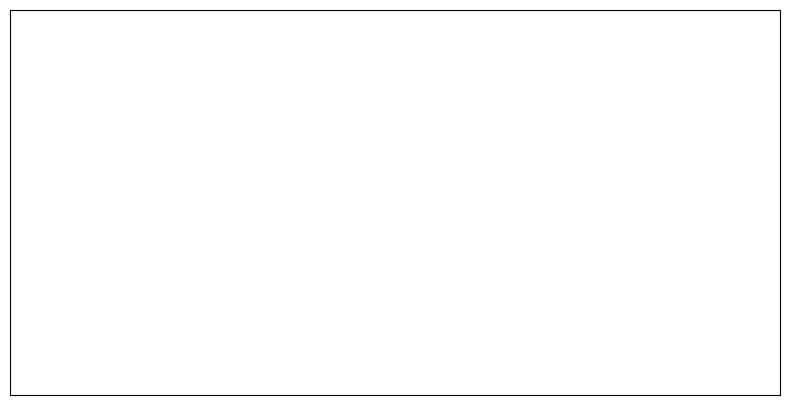

In [13]:
# Define the plot
import cartopy.crs as ccrs
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(10, 5))

# Plot the data
predictions_ds.P_minus_E_cumulative.sel(time=24).plot(
    x='longitude',
    y='latitude',
    robust=True,
    ax=ax,
    transform=ccrs.PlateCarree(),
    aspect=2,
    size=2
)

# Add cartographic features
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAND, edgecolor='black', facecolor='lightgray', alpha=0.5)

# Customize the title and labels
ax.set_title("Cumulative P minus E at time=24", fontsize=12)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

## Data Analysis

In [12]:
#!pip install numpy==2.0
!pip install numba

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import norm
#from numba import jit

/home/kit/iti/kd5572/miniconda3/envs/neuralgcm/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [13]:

ersst_path = "./data/tos_Omon_GISS-E2-1-G_historical_r1i1p5f1_gn_200101-201412.nc"
ersst_data = xr.open_dataset(ersst_path)

## Temperature

In [ ]:
predictions_ds['temperature'].sel(
    time=slice(outer_steps),
    latitude=lat_bounds,
    longitude=lon_bounds
).plot(x='longitude', y='latitude', row='time', col='model', robust=True, aspect=2, size=2)

## SST from NeuralGCM

In [26]:
# Install and import necessary libraries
!pip install dask
import xarray as xr
import dask

lat_bounds = slice(34, 51)  # Latitude bounds (51°N to 34°N)
lon_bounds = slice(-20, 10)  # Longitude bounds (-20°W to 10°E)

# Extract SST with lazy loading
sst = predictions_ds['temperature'].sel(
    time=slice(outer_steps),
    latitude=lat_bounds,
    longitude=lon_bounds)
print("1 done - SST extracted")

# Align time indexing for consistent processing
sst['time'] = sst.indexes['time']
print(sst)
print("done")

# Calculate climatological mean SST
climatological_mean_sst = sst.mean(dim='time').persist()  # Persist in memory for repeated use
print("2 done - Climatological mean computed")
print(climatological_mean_sst)
# Compute SST anomalies
sst_anomalies = (sst - climatological_mean_sst).persist()  # Persist anomalies for further analysis
print("3 done - SST anomalies computed")
print(sst_anomalies)

/home/kit/iti/kd5572/miniconda3/envs/neuralgcm/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


1 done - SST extracted
<xarray.DataArray 'temperature' (time: 1, level: 37, longitude: 4, latitude: 6)> Size: 4kB
Array([[[[260.71786, 258.4826 , 259.44916, 259.7579 , 258.00037,
          258.5966 ],
         [259.0168 , 260.3707 , 260.3911 , 260.41895, 258.80032,
          257.05673],
         [258.18634, 259.91266, 261.14398, 261.40628, 259.20377,
          259.2863 ],
         [256.83063, 259.40393, 259.12277, 259.39252, 259.23065,
          260.7131 ]],

        [[258.9259 , 258.66553, 258.96466, 257.1871 , 254.11482,
          255.5925 ],
         [255.67313, 257.61194, 259.24307, 259.44748, 256.84262,
          253.84254],
         [257.28586, 258.39304, 258.676  , 259.36676, 256.88586,
          256.33716],
         [255.32198, 257.14993, 257.96658, 256.59662, 253.48524,
          257.35684]],

        [[252.42291, 253.29253, 252.6993 , 250.2302 , 247.0978 ,
          249.3853 ],
...
         [285.45093, 285.60287, 287.00934, 287.28052, 283.08945,
          280.6232 ]],

      

[[260.71786 258.4826  259.44916 259.7579  258.00037 258.5966 ]
 [259.0168  260.3707  260.3911  260.41895 258.80032 257.05673]
 [258.18634 259.91266 261.14398 261.40628 259.20377 259.2863 ]
 [256.83063 259.40393 259.12277 259.39252 259.23065 260.7131 ]]
<xarray.DataArray 'temperature' (longitude: 4, latitude: 6)> Size: 96B
array([[288.4681 , 290.08694, 291.01642, 287.88657, 285.32144, 282.6883 ],
       [288.6023 , 288.33408, 290.88235, 288.46188, 285.2438 , 281.86157],
       [288.97202, 287.40118, 289.5407 , 289.21103, 285.03055, 282.27252],
       [288.0501 , 287.6228 , 288.25058, 288.9435 , 285.51282, 283.08377]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float64 32B 0.0 2.812 5.625 8.438
  * latitude   (latitude) float64 48B 34.88 37.67 40.46 43.25 46.04 48.84
    level      int64 8B 1000
<xarray.DataArray 'level' (level: 37)> Size: 296B
array([   1,    2,    3,    5,    7,   10,   20,   30,   50,   70,  100,  125,
        150,  175,  200,  225,  250,  300,  350,

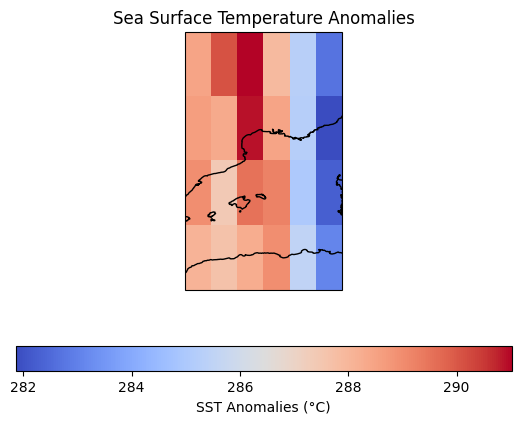

In [28]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
print(climatological_mean_sst.isel(level=0).values)
print(climatological_mean_sst.isel(level=-1))

print(climatological_mean_sst['level'])
# Subset the data
subset_sst = climatological_mean_sst.sel(latitude=lat_bounds, longitude=lon_bounds)

# Example for one time step
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
#ax.set_global()
ax.coastlines()
sst_plot = ax.imshow(
    subset_sst.isel(level=-1),
    extent=[
        subset_sst['longitude'].min(),
        subset_sst['longitude'].max(),
        subset_sst['latitude'].min(),
        subset_sst['latitude'].max(),
    ],
    transform=ccrs.PlateCarree(), cmap='coolwarm', origin='upper'
)



plt.colorbar(sst_plot, ax=ax, orientation='horizontal', label='SST Anomalies (°C)')
plt.title('Sea Surface Temperature Anomalies')
plt.show()


## SST Pattern  
<span style="color:green"></span> Compute anomalies, trends, or indices such as the Atlantic Multidecadal Oscillation (AMO) to understand SST variations over time. \

In [14]:
# Subset the data
lat_bounds = [slice(34, 45), slice(34, 51)] 
lon_bounds = [slice(-25, 19), slice(-20, 10)]  
start_time = '2005-01-01'
end_time = '2022-06-16'
sst_subset = ersst_data['tos'].sel(time=slice(start_time, end_time),
                                   lat=lat_bounds[0],
                                   lon=lon_bounds[0])
print(sst_subset.values)

# Calculate the climatology (mean over the period)
sst_subset['time'] = sst_subset.indexes['time']

climatology = sst_subset.mean(dim='time') 

print(climatology)
print(climatology.dims)
print(climatology.shape)
# Compute SST anomalies
sst_anomalies = sst_subset - climatology

sst_anomalies.to_netcdf('sst_anomalies.nc')

# Calculate the AMO index (example)
amo_index = sst_anomalies.mean(dim=['lat', 'lon'])

print(amo_index)

[[[       nan        nan        nan ... 17.161402  17.22317   17.031183 ]
  [16.820246  16.605341  16.54394   ... 16.665552  16.126245  16.093073 ]
  [15.9109745 16.127558  16.110926  ... 16.11056   15.816431  15.386805 ]
  [15.032404  14.926813  15.1045475 ... 15.282648  13.96673   14.784021 ]
  [       nan 14.09704   14.427637  ... 12.867334  13.254328  13.549036 ]
  [       nan        nan        nan ... 10.855951         nan        nan]]

 [[       nan        nan        nan ... 16.600336  16.717554  16.492823 ]
  [16.512873  16.13537   16.027826  ... 16.245935  15.773066  15.636133 ]
  [15.727381  15.836603  15.802759  ... 15.708582  15.480555  14.887781 ]
  [14.812159  14.666681  14.887079  ... 15.118921  13.488276  14.217493 ]
  [       nan 13.621759  14.30105   ... 12.288111  12.747187  13.042719 ]
  [       nan        nan        nan ... 10.951166         nan        nan]]

 [[       nan        nan        nan ... 16.27743   16.375025  16.16421  ]
  [16.551538  16.116693  15.899836

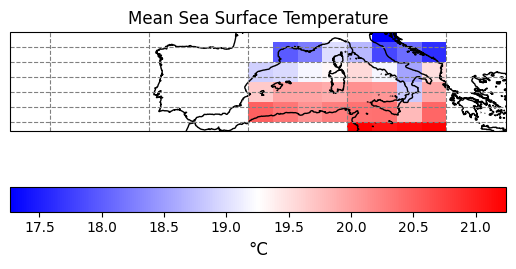

In [15]:
region = [-24, 26, 35, 45] 

plt.figure()
ax = plt.axes(projection=cartopy.crs.PlateCarree(central_longitude=0))
ax.set_global()
ax.set_extent(region, crs=cartopy.crs.PlateCarree())
ax.gridlines(linestyle='--',color='gray')
ax.coastlines()

temp_cartopy = ax.pcolormesh(
    sst_subset['lon'], 
    sst_subset['lat'], 
    climatology, 
    transform=cartopy.crs.PlateCarree(), 
    shading='auto', 
    cmap='bwr'
)
colorbar = plt.colorbar(temp_cartopy, ax=ax, orientation='horizontal', label='Mean Temperature')
colorbar.set_label("°C",size=12,rotation=0)
plt.title("Mean Sea Surface Temperature")
plt.show()

In [16]:
print(sst_anomalies.dims)
print(sst_anomalies)

('time', 'lat', 'lon')
<xarray.DataArray 'tos' (time: 120, lat: 6, lon: 8)> Size: 23kB
array([[[        nan,         nan,         nan, ..., -3.9139977 ,
         -3.9350433 , -4.191416  ],
        [-3.6703854 , -3.7083683 , -3.5631523 , ..., -3.6940918 ,
         -3.671362  , -4.3581963 ],
        [-3.7588577 , -3.835823  , -3.8574028 , ..., -3.9541893 ,
         -3.0226078 , -4.541548  ],
        [-3.8611698 , -4.0363636 , -4.079979  , ..., -3.9075336 ,
         -4.581421  , -4.7323666 ],
        [        nan, -3.8719711 , -3.8023014 , ..., -4.951601  ,
         -4.856676  , -4.0844955 ],
        [        nan,         nan,         nan, ..., -6.4079666 ,
                 nan,         nan]],

       [[        nan,         nan,         nan, ..., -4.4750633 ,
         -4.4406586 , -4.7297764 ],
        [-3.9777584 , -4.178339  , -4.0792656 , ..., -4.1137085 ,
         -4.024542  , -4.815136  ],
        [-3.9424515 , -4.1267776 , -4.1655693 , ..., -4.356167  ,
         -3.3584843 , -5.0405

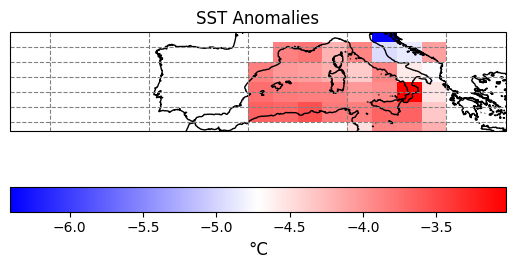

In [17]:
plt.figure()
ax = plt.axes(projection=cartopy.crs.PlateCarree(central_longitude=0))
ax.set_global()
ax.set_extent(region, crs=cartopy.crs.PlateCarree())
ax.gridlines(linestyle='--',color='gray')
ax.coastlines()

temp_cartopy = ax.pcolormesh(sst_subset['lon'], sst_subset['lat'], sst_anomalies[0,:,:], transform=cartopy.crs.PlateCarree(), shading='auto',cmap='bwr')
colorbar = plt.colorbar(temp_cartopy, ax=ax, orientation='horizontal', label='SST Anomalies')
colorbar.set_label("°C",size=12,rotation=0)
plt.title("SST Anomalies")
plt.show()

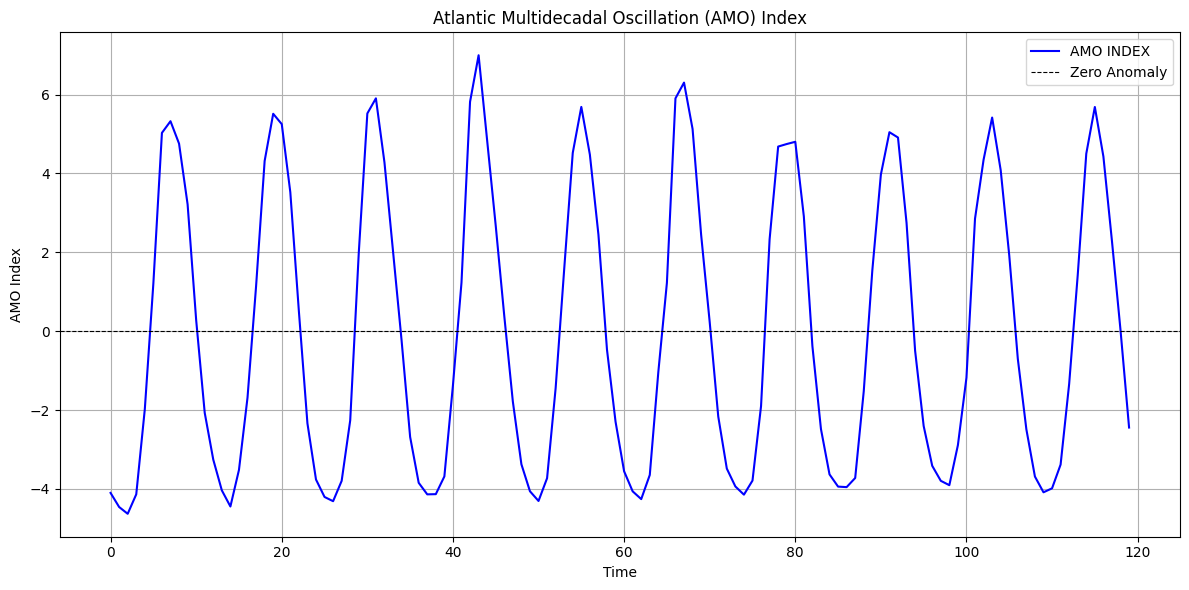

In [18]:
plt.figure(figsize=(12,6))
plt.plot(amo_index, label="AMO INDEX", color="b")
plt.axhline(0, color="k", linestyle="--", linewidth=0.8, label="Zero Anomaly")
plt.title("Atlantic Multidecadal Oscillation (AMO) Index")
plt.xlabel("Time")
plt.ylabel("AMO Index")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## RMSE SST
true values from file and predicted_values from neuralgcm

In [ ]:
rmse = np.sqrt(np.mean((true_values - predicted_values) ** 2))

## SPEI

In [24]:
# Function to calculate SPEI directly 
def calculate_spei(predictions_ds, scale=3):
    import numpy as np
    import xarray as xr

    def thornthwaite(temp, lat):
        """
        Thornthwaite method to estimate potential evapotranspiration (PET).
        """
        temp_celsius = temp - 273.15  # Convert from Kelvin to Celsius
        if temp_celsius > 0:
            I = (temp_celsius / 5) ** 1.514
            a = (6.75e-7 * I ** 3) - (7.71e-5 * I ** 2) + (1.792e-2 * I) + 0.49239
            PET = 16 * ((10 * temp_celsius / I) ** a)  # Simplified Thornthwaite formula
        else:
            PET = 0  # PET is zero if temperature is below or equal to zero
    
        return PET



    def compute_spei(D, scale=3):
        """
        Compute Standardized Precipitation Evapotranspiration Index (SPEI) at a given scale.
        """
        rolling_mean = D.rolling(time=scale, center=False).mean()
        rolling_std = D.rolling(time=scale, center=False).std()
        spei = (rolling_mean - rolling_mean.mean(dim="time")) / rolling_std
        print("2")
        return spei

    # Step 1: Calculate PET
    latitude = predictions_ds['latitude']
    temperature = predictions_ds['temperature'].sel(level=1000)  # Near-surface temperature
    latitude_value = latitude.mean().item()  # Simplified to one value for now
    PET = xr.apply_ufunc(thornthwaite, temperature, latitude_value, vectorize=True)

# Calculate D
    P_minus_E = predictions_ds['P_minus_E_cumulative']
    D = P_minus_E - PET
# Compute SPEI
    SPEI = compute_spei(D, scale=scale)
    print("3")
    return SPEI

SPEI_result = calculate_spei(predictions_ds)
print(SPEI_result)
spei_avg = SPEI_result.mean(dim=['latitude', 'longitude'])
time = spei_avg['time']
spei_values = spei_avg.values



2
3
<xarray.DataArray (time: 10, longitude: 128, latitude: 64)> Size: 328kB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,      

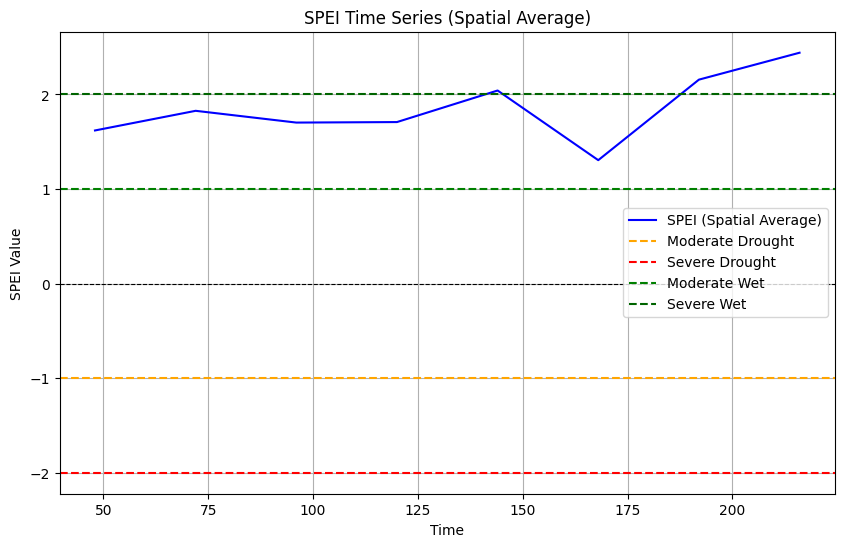

In [25]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(time, spei_values, label='SPEI (Spatial Average)', color='blue')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)  # Reference line for neutral SPEI
plt.axhline(-1, color='orange', linestyle='--', label='Moderate Drought')
plt.axhline(-2, color='red', linestyle='--', label='Severe Drought')
plt.axhline(1, color='green', linestyle='--', label='Moderate Wet')
plt.axhline(2, color='darkgreen', linestyle='--', label='Severe Wet')
plt.title("SPEI Time Series (Spatial Average)")
plt.xlabel("Time")
plt.ylabel("SPEI Value")
plt.legend()
plt.grid()
plt.show()

## Adding later

In [ ]:
from PIL import Image
from IPython.display import display

img = Image.open('images/Spain_range_1.png')
display(img)

In [ ]:
from PIL import Image
from IPython.display import display

img = Image.open('images/Spain_range_1.png')
display(img)

In [ ]:
img = Image.open('images/Spain_range_1.png')
display(img)

In [ ]:
#import signal
#import sys
#import numpy as np
#import jax
#
# Parameters for 30-year rollout
#years = 30
#days_per_year = 365  # Exclude leap years for simplicity
#inner_steps = 24  # Save model outputs every 24 hours
#hours_per_day = 24
outer_steps = (days_per_year * years * hours_per_day) // inner_steps  # Total steps for 30 years
timedelta = np.timedelta64(inner_steps, 'h')  # Time interval between model outputs
times = np.arange(outer_steps) * inner_steps  # Time axis in hours

# Placeholder model and data (replace with actual implementations)
# model = ...
# eval_era5 = ...

class GracefulExit:
    """Handles graceful exit and file closing."""
    def __init__(self, file):
        self.file = file
        self.is_running = True

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        self.cleanup()

    def cleanup(self):
        print("Shutting down gracefully...")
        if not self.file.closed:
            self.file.close()
        self.is_running = False

# Signal handler to trigger cleanup
def handle_signal(signum, frame):
    global graceful_exit_context
    graceful_exit_context.cleanup()

# Register signal handlers
signal.signal(signal.SIGINT, handle_signal)
signal.signal(signal.SIGTERM, handle_signal)

output_file = "30_year_rollout_predictions.nc"

with open(output_file, "w") as nc_file:
    with GracefulExit(nc_file) as graceful_exit_context:
        try:
            # Initialize model state
            print("Initializing model state...")
            inputs = model.inputs_from_xarray(eval_era5.isel(time=0))
            input_forcings = model.forcings_from_xarray(eval_era5.isel(time=0))
            rng_key = jax.random.key(42)  # Optional for deterministic models
            initial_state = model.encode(inputs, input_forcings, rng_key)

            # Use persistence for forcing variables (e.g., SST and sea ice cover)
            print("Using persistent forcing variables...")
            all_forcings = model.forcings_from_xarray(eval_era5.head(time=1))

            # Make forecast
            print(f"Starting 30-year rollout with {outer_steps} steps...")
            final_state, predictions = model.unroll(
                initial_state,
                all_forcings,
                steps=outer_steps,
                timedelta=timedelta,
                start_with_input=True,
            )

            # Convert predictions to xarray dataset
            print("Converting predictions to xarray.Dataset...")
            #print(predictions)
            predictions_ds = model.data_to_xarray(predictions, times=times)
            print(predictions_ds)
            # Save results to a NetCDF file
            print("Applying chunking to the dataset...")
            #chunked_ds = predictions_ds.chunk({'time': 100})  # Adjust chunk size as needed
            #chunked_ds.to_netcdf(output_file, mode='w', engine='netcdf4')


            # Final message
            print("30-year rollout completed successfully.")

        except Exception as e:
            print(f"An error occurred: {e}")
            graceful_exit_context.cleanup()
        finally:
            print("Execution stopped.")
